In [1]:
import numpy as np
import numpy as np 
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants as c
import pandas as pd 
import sys 
import dask.dataframe as dd 
import time
import argparse
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import regionprops, label
from skimage.feature import blob_dog

    ID  amplitude      x      y  width_x  width_y  angle  line_peak  \
0  0.0       3.10  124.0  213.0     3.39     4.67  56.66       3.30   
1  0.0       2.94  150.0  220.0     2.91     3.21  67.17       2.66   

   line_fwhm      z  sp_idx  
0       4.06  80.61    0.75  
1       9.86  41.82   -0.83  


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


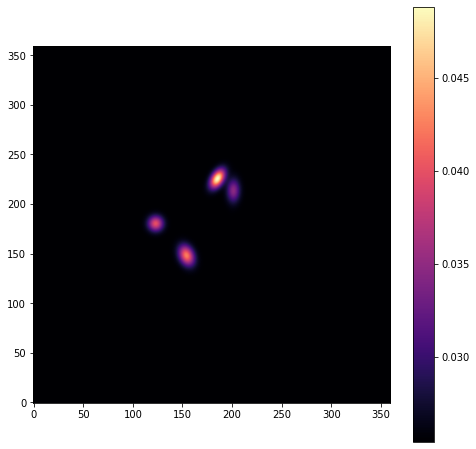

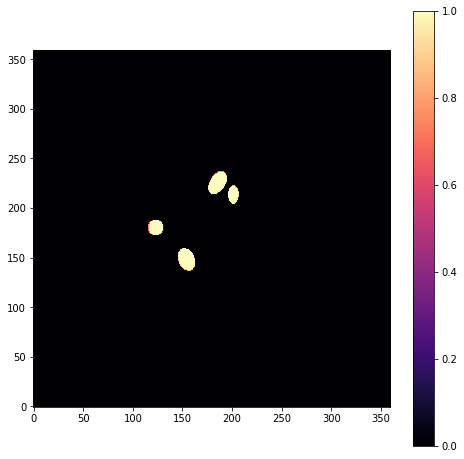

2


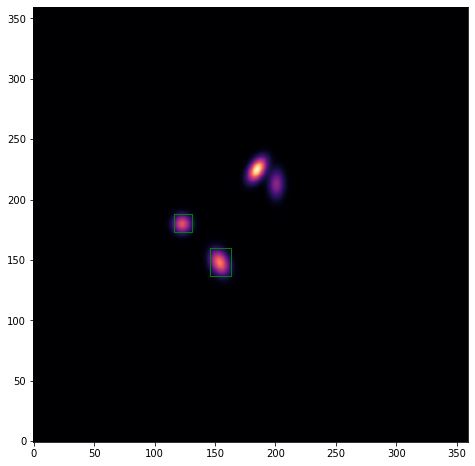

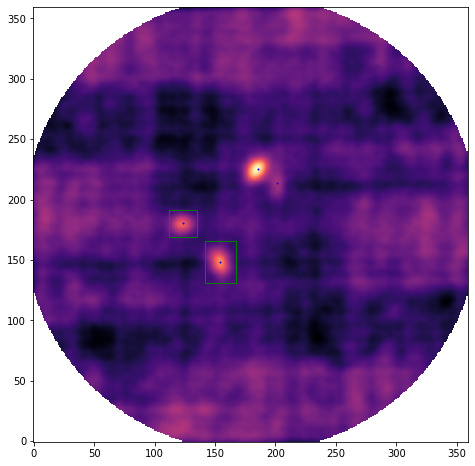

In [6]:
input_dir = "models"
output_dir = "sims"
catalogue_name = "params.csv"
input_dataframe = pd.read_csv(os.path.join(input_dir, catalogue_name))
i = 0
lines = input_dataframe.loc[input_dataframe.ID == i]
data, header = fits.getdata(os.path.join(output_dir, 'gauss_cube_sim_{}.dirty.fits'.format(i)), header=True)
data = data[0]
print(lines)
w = WCS(header).dropaxis(3).dropaxis(2)
xs, ys, wxs, wys, lfwhms, z = lines["x"].astype(int), lines["y"].astype(int), lines["width_x"].astype(int), lines["width_y"].astype(int), lines["line_fwhm"].astype(int), lines['z'].astype(int)
ids, amplitudes, angles, lpeaks, sp_idxs = lines["ID"].astype(int), lines["amplitude"].astype(float), lines["angle"].astype(float), lines["line_peak"].astype(float), lines["sp_idx"].astype(float)
pixel_coords = np.column_stack((xs, ys))
ras, decs = w.pixel_to_world(pixel_coords)
cdata = fits.getdata(os.path.join(output_dir, 'gauss_cube_sim_{}.skymodel.fits'.format(i)))[0]
tseg = np.sum(cdata, axis=0).copy()
plt.figure(figsize=(8, 8))
plt.imshow(tseg, origin="lower", cmap="magma")
plt.colorbar()
plt.show()
tseg[tseg >= 0.03] = 1
tseg = tseg.astype(int)
plt.figure(figsize=(8, 8))
plt.imshow(tseg, origin="lower", cmap="magma")
plt.colorbar()
plt.show()
props = regionprops(label(tseg, connectivity=2))
x0s, y0s, x1s, y1s = [], [], [], []
for prop in props:
    y0, x0, y1, x1 = prop.bbox
    x0s.append(x0)
    x1s.append(x1)
    y1s.append(y1)
    y0s.append(y0)
x0s = np.array(x0s)
x1s = np.array(x1s)
y0s = np.array(y0s)
y1s = np.array(y1s)
print(len(xs))
widths = x1s - x0s
heights = y1s - y0s
x, y = x0s + 0.5 * (widths), y0s + 0.5 * (heights)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.imshow(np.sum(cdata, axis=0), origin="lower", cmap="magma")
for k in range(len(xs)):
    rect = patches.Rectangle(xy=(x0s[k], y0s[k]), 
                width=widths[k],
                height=heights[k],
                facecolor="none",
                edgecolor='green')
    ax.add_patch(rect)
plt.show()

factor = 1.5
x0s = x - 0.5 * (factor * widths)
x1s = x + 0.5 * (factor * widths)
y0s = y - 0.5 * (factor * heights)
y1s = y + 0.5 * (factor * heights)
widths = x1s - x0s
heights = y1s - y0s

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.imshow(np.sum(data, axis=0), origin="lower", cmap="magma")
for k in range(len(xs)):
    rect = patches.Rectangle(xy=(x0s[k], y0s[k]), 
                width=widths[k],
                height=heights[k], 
                facecolor="none",
                edgecolor='green')
    ax.add_patch(rect)
plt.scatter(x, y, c="blue", s=1)
plt.show()


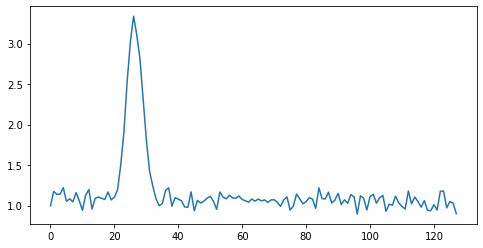

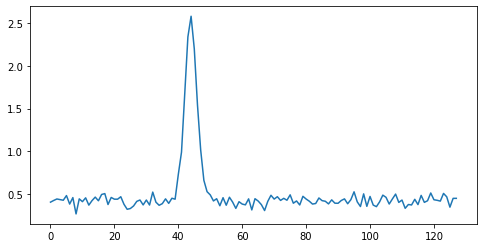

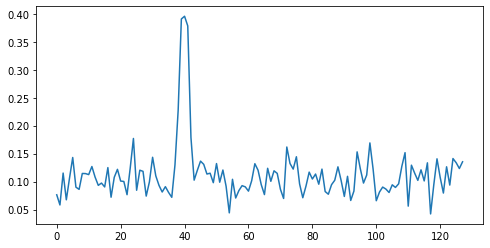

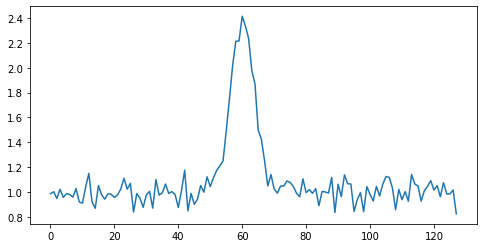

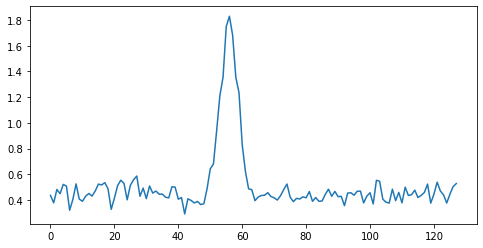

In [13]:
spectra = np.array([
    np.sum(data[:, y0s[j]: y1s[j], x0s[j]:x1s[j]], 
    axis=(1, 2)) for j in range(len(lines))
])
for spectrum in spectra:
    plt.figure(figsize=(8, 4))
    plt.plot(spectrum)
    plt.show()